## Pre-requisites

This Notebook requires the following to be installed on one's machine:

* **openmc** (tested on version 0.15.3)
* **beavrs**

**NOTE**: You can install the `beavrs` Python module by running the following in the terminal from the directory BEAVRS/models/openmc:

```
$ pip install . --user
```

In [ ]:
import openmc
import beavrs.builder
import beavrs.constants as c
from IPython.display import Image
import os

In [ ]:
# This example assumes the OPENMC_CROSS_SECTIONS environment variable has already been set 
# so that OpenMC can be called without having to specify the cross section data library.
# For users who do not have this environment variable set, please uncomment the following
# line and update the library path to the correct cross_sections.xml file
# os.environ["OPENMC_CROSS_SECTIONS"] = '/path/to/cross_sections.xml'

## Create BEAVRS Model

In [2]:
# Instantiate a BEAVRS object from the mit-crpg/PWR_benchmarks repository
b = beavrs.builder.BEAVRS()

The BEAVRS model represented by variable `b` encapsulates the fully-detailed 3D BEAVRS core geometry and materials built using the OpenMC Python API.

## Create "geometry.xml"

We wish to extract a fuel assembly from the BEAVRS `Geometry` object for our simulation. We will first extract a Python `list` of all `Lattice` objects in the `Geometry` using the `Geometry.get_all_lattices()` routine:

In [3]:
# Get all OpenMC Lattices in a Python list
all_latts = b.openmc_geometry.get_all_lattices()

There are a number of different fuel assembly `Lattices` in the BEAVRS model, each of which has been assigned a unique string name. let's loop over all `Lattices` and report the string name for each `Lattice`:

In [4]:
# Print the name of each Lattice
for id, latt in all_latts.items():
    print(id, latt.name)

762 Core Lattice
336 Fuel 3.1% enr no instr no BAs
354 Fuel 3.1% enr no instr 6S
339 Fuel 3.1% enr instr no BAs
357 Fuel 3.1% enr instr 6S
444 Fuel 3.1% enr no instr RCCA SA
408 Fuel 3.1% enr no instr 16
153 Fuel 1.6% enr instr RCCA B
414 Fuel 3.1% enr no instr 20
159 Fuel 1.6% enr instr RCCA C
150 Fuel 1.6% enr no instr RCCA B
402 Fuel 3.1% enr no instr 15SE
270 Fuel 2.4% enr no instr 16
186 Fuel 1.6% enr no instr RCCA SD
174 Fuel 1.6% enr no instr RCCA SB
273 Fuel 2.4% enr instr 16
180 Fuel 1.6% enr no instr RCCA SC
396 Fuel 3.1% enr no instr 15SW
447 Fuel 3.1% enr instr RCCA SA
300 Fuel 2.4% enr no instr RCCA D
60 Fuel 1.6% enr no instr no BAs
240 Fuel 2.4% enr no instr 12
195 Fuel 1.6% enr instr RCCA SE
63 Fuel 1.6% enr instr no BAs
189 Fuel 1.6% enr instr RCCA SD
363 Fuel 3.1% enr instr 6E
147 Fuel 1.6% enr instr RCCA A
156 Fuel 1.6% enr no instr RCCA C
366 Fuel 3.1% enr no instr 6W
243 Fuel 2.4% enr instr 12
177 Fuel 1.6% enr instr RCCA SB
192 Fuel 1.6% enr no instr RCCA SE
144 F

Now that we know the names of all of the `Lattices` in the BEAVRS `Geometry`, let's select out the one we wish to model.

In [5]:
# Find the 1.6% enriched fuel lattice w/o BAs
assembly_name = 'Fuel 1.6% enr instr no BAs'
for id, latt in all_latts.items():
    if latt.name == assembly_name:
        assembly = latt

We can inspect our chosen fuel assembly using OpenMC's built-in string representation for the object:

In [6]:
assembly

RectLattice
	ID             =	63
	Name           =	Fuel 1.6% enr instr no BAs
	Shape          =	(17, 17)
	Lower Left     =	[-10.70864, -10.70864]
	Pitch          =	[1.25984, 1.25984]
	Outer          =	None
	Universes      
15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 
15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 
15 15 15 15 15 27 15 15 27 15 15 27 15 15 15 15 15 
15 15 15 27 15 15 15 15 15 15 15 15 15 27 15 15 15 
15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 
15 15 27 15 15 27 15 15 27 15 15 27 15 15 27 15 15 
15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 
15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 
15 15 27 15 15 27 15 15 33 15 15 27 15 15 27 15 15 
15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 
15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 
15 15 27 15 15 27 15 15 27 15 15 27 15 15 27 15 15 
15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 
15 15 15 27 15 15 15 15 15 15 15 15 15 27 15 15 15 
15 15 15 15 15 27 15 15 27 15 15 27 15 15 15 15 1

We need to construct a sub-geometry encapsulating only this fuel assembly rather than the entire BEAVRS core. We will do this by first creating a "root" cell and fill it with our fuel assembly:

In [7]:
# Create surface objects for our "root" cell"
lattice_sides = openmc.model.RectangularPrism(17*c.pinPitch, 17*c.pinPitch,
                                              axis ='z',
                                              boundary_type='reflective')
min_z = openmc.ZPlane(z0=c.struct_LowestExtent, boundary_type='vacuum')
max_z = openmc.ZPlane(z0=c.struct_HighestExtent, boundary_type='vacuum')

# Create a "root" cell filled by the fuel assembly
root_cell = openmc.Cell(name='root cell',
                        fill=assembly,
                        region=-lattice_sides & +min_z & -max_z
                       )

We then create a "root" universe and add our "root" cell to it:

In [8]:
# Create a "root" universe with ID=0 and add the "root" cell to it
root_univ = openmc.Universe(name='root universe', cells=[root_cell])

Lastly, the "root" universe must be attached to a new OpenMC `Geometry` object representing this new sub-geometry:

In [9]:
# Create an OpenMC Geometry around root Universe
sub_geometry = openmc.Geometry(root_univ)

Finally, we are ready to create a "geometry.xml" input file for OpenMC! We simply export it to XML as follows:

In [10]:
# Export the OpenMC Geometry to a "geometry.xml" file
sub_geometry.export_to_xml()

## Create "materials.xml"

Now we need to create materials for our geometry. This is very easy to do with the `b.write_openmc_materials()` routine. The one disadvantage of this is that it will write *all* materials for the entire BEAVRS geometry to a "materials.xml" file, most of which are not used in our sub-geometry for a single fuel assembly. Instead, we can write out only those materials that are in our geometry as follows:

In [11]:
# Get a list of all OpenMC Materials
all_materials = sub_geometry.get_all_materials()

# Create a MaterialsFile object
materials = openmc.Materials(all_materials.values())

# Export the OpenMC Materials to a "materials.xml" file
materials.export_to_xml()

## Create "settings.xml" 

Now for the easy part :-) Let's create a "settings.xml" file:

In [12]:
# Create a MaterialsFile object
settings = openmc.Settings()

# Set any settings of interest
settings.batches = 150
settings.inactive = 10
settings.particles = 1000

# Use a bounding box to define the starting source distribution
lower_left = [-17*c.pinPitch/2, -17*c.pinPitch/2, c.fuel_ActiveFuel_bot]
upper_right = [+17*c.pinPitch/2, +17*c.pinPitch/2, c.fuel_ActiveFuel_top]
settings.source = openmc.IndependentSource(
    openmc.stats.Box(lower_left, upper_right), constraints={'fissionable': True})

# Set temperature handling method for cross section data
settings.temperature = {'method': 'interpolation',
                            'default': c.operating_temperature,
                            'range': (300.0, 600.0),
                            'tolerance': 100.0}

# Export the settings to a "settings.xml" file
settings.export_to_xml()

## Create "plots.xml"

In [13]:
# Create a single plot using default paramters (basis='xy', origin=(0,0,230))
plot = openmc.Plot(plot_id=1)
plot.width = [17*c.pinPitch, 17*c.pinPitch]
plot.origin = (0.0, 0.0, 230.0)

# Create a PlotsFile object and add our plot to it
plot_file = openmc.Plots([plot])

# Export the plots to a "plots.xml" file
plot_file.export_to_xml()

With the "plots.xml" file, we can now generate and view the plot. We must first instantiate an `openmc.Executor` object and then ask it to plot the geometry(equivalent to running `openmc -p` from within the terminal).

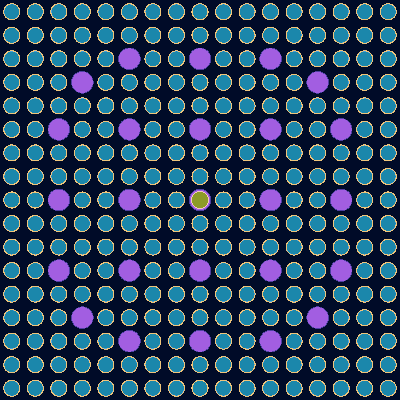

In [17]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

# Display the plot inline
Image(filename='plot_1.png', width=250, height=250)

## Create "tallies.xml"

I'm not exactly sure what you need in the way of tallies, but perhaps I can get you started with a fission tally in the instrument tube. First, let's inspect the names for all of the `Cells` in the geometry using the `all_material_cells` list:

In [26]:
all_material_cells = sub_geometry.get_all_material_cells()
for id, cell in all_material_cells.items():
    print(cell.name)

Fuel rod - 1.6% enr axial 0: Borated Water
Fuel rod - 1.6% enr axial 1: SS SPN
Fuel rod - 1.6% enr axial 2: Zircaloy 4
Fuel rod - 1.6% enr axial 5: Zircaloy 4
Fuel rod - 1.6% enr axial 6: Borated Water
Fuel rod - 1.6% enr axial 7: SS SPN
Fuel rod - 1.6% enr axial top: Borated Water
Fuel rod active region - 1.6% enr radial 0: Fuel 1.6%
Fuel rod active region - 1.6% enr radial 1: Helium
Fuel rod active region - 1.6% enr radial outer: Zircaloy 4
Fuel rod plenum radial 0: Inconel 718
Fuel rod plenum radial 1: Helium
Fuel rod plenum radial outer: Zircaloy 4
Grids axial universe axial 0: Borated Water
Grids axial universe axial 1: Water SPN
Grids axial universe axial 2: Borated Water
Grids axial universe axial 4: Borated Water
Grids axial universe axial 6: Borated Water
Grids axial universe axial 8: Borated Water
Grids axial universe axial 10: Borated Water
Grids axial universe axial 12: Borated Water
Grids axial universe axial 14: Borated Water
Grids axial universe axial 16: Borated Water
G

Perhaps you'd like a tally in one of these cells. First, we need to extract the cell(s) of interest:

In [22]:
cell_name = 'Instrument tube thimble radial 0: Air'
for id, cell in all_material_cells.items():
    if cell.name == cell_name:
        my_cell = cell

Let's tally the fast/thermal scatter and absorption rates for all nuclides in our cell. We create a `Tally` to do so as follows:

In [23]:
# Instantiate a really cool tally
tally = openmc.Tally(name='a really cool tally')

# Instantiate a cell filter
cell_filter = openmc.CellFilter(bins=[my_cell.id])

# Instantiate energy filter
energy_filter = openmc.EnergyFilter([0., 0.625e-6, 20.])

tally.filters = [cell_filter, energy_filter]

# Add the scores of interest to the tally
tally.scores = ['scatter', 'absorption']

# Add all nuclides to the tally for kicks
tally.nuclides = my_cell.fill.get_nuclides()

Next, we simply need to add our `Tally` object(s) to a `TalliesFile` object and export them to a "tallies.xml" file:

In [24]:
# Instantiate an empty TalliesFile
tallies_file = openmc.Tallies()

# Add our tally(ies) to the file
tallies_file.append(tally)

# Export the tallies to a "tallies.xml" file
tallies_file.export_to_xml()

## Run OpenMC!

We can run OpenMC from within the notebook if we wish. Wow, isn't this so much more powerful than ASCII!

In [25]:
# Run OpenMC with 2 MPI processes
openmc.run(mpi_args=['mpiexec', '-n', '2'])

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Analyze Tally Data

In [21]:
# Instantiate a StatePoint object
from openmc.statepoint import StatePoint
filename = 'statepoint.{}.h5'.format(settings.batches)
sp = StatePoint(filename)

In [22]:
# Inspect the StatePoint's tallies
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	a really cool tally
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	O16 O17 N14 N15 Ar36 Ar38 Ar40 C0 
 	Scores         =	['scatter', 'absorption']
 	Estimator      =	tracklength}

In [23]:
# Get a Pandas DataFrame of the tally data
tally = sp.get_tally(name='a really cool tally')
tally.get_pandas_dataframe()

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,145,0.000000e+00,6.250000e-07,O16,scatter,0.000000e+00,0.000000e+00
1,145,0.000000e+00,6.250000e-07,O16,absorption,0.000000e+00,0.000000e+00
2,145,0.000000e+00,6.250000e-07,O17,scatter,0.000000e+00,0.000000e+00
3,145,0.000000e+00,6.250000e-07,O17,absorption,0.000000e+00,0.000000e+00
4,145,0.000000e+00,6.250000e-07,N14,scatter,0.000000e+00,0.000000e+00
5,145,0.000000e+00,6.250000e-07,N14,absorption,0.000000e+00,0.000000e+00
6,145,0.000000e+00,6.250000e-07,N15,scatter,0.000000e+00,0.000000e+00
7,145,0.000000e+00,6.250000e-07,N15,absorption,0.000000e+00,0.000000e+00
8,145,0.000000e+00,6.250000e-07,Ar36,scatter,0.000000e+00,0.000000e+00
9,145,0.000000e+00,6.250000e-07,Ar36,absorption,0.000000e+00,0.000000e+00


And I'll leave it up to you at this point :-)